# Project Definition

## Project Overview

Imagine you are working as a data scientist for a popular digital media provider such as Spotify. Many of users stream their favorite songs to your service every day either using a free tier that places ads between the songs or the premium tier that charges a flat monthly rate. users can upgrade, downgrade or cancel their services any time, so it's crucial to make sure that they love the service.

Everytime a user interacts with the service while they're playing a song, logging out, watching an ad etc, it generates data. All of this data contains the key insights for keeping your users happy and helping your business thrive. It's your job as a Data Scientist to predict when a user is likely to churn, which either means downgrading from premium or cancelling their service all together.



### Problem Statement
If you can accurately identify these users before they leave, you will be able to offer them incentives to keep them as a customer for longer, potentially saving your business tons of money in revenue.

To tackle this project, we are given a medium sized data set (half a million rows) that contains the events we mentioned above. We need to load, clean and explore the data with Spark.

We will build features from the data and train machine learning models to predict which users will churn from our digital music library. 

### Metrics 

As you will see, the number of users who churn are small compared to the total number of users. In this case, accuracy cannot be a good metric for evaluating the performance of our model, since an untrained model could predict that not a single user will churn and still get a good accuracy score (~80%) since the model is right for the case of the majority of users who don't churn.

For this reason, we will be using F1 score which is a function of precision and recall, and punished type I and type II errors equally. 



# Analysis

In [1]:

import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-3b47280a-b98d-451e-b74b-5bfd0ae9d223',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token',
    'api_key': 'AHPuO1llG7iDCc-k_7LYWK41DDtN3k_spCOqxSCSlH5z'
}

configuration_name = 'os_0a3bc7356d414e1989a7ebc516f1e2fe_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

# df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-krujxod0bfnnvr'))
# df_data_1.take(5)


Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190806224425-0000
KERNEL_ID = a2a6e83b-0d2f-4c67-8044-28eb1830e307


In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull
from pyspark.sql.types import IntegerType

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Spark Project") \
    .getOrCreate()

In [13]:
data = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-krujxod0bfnnvr'))

## Data Exploration

Let's look at the first few rows of the data. Spark dataframes will show in a different format compared to pandas dataframes

In [14]:
data.take(2)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98')]

In [15]:
print((data.count(), len(data.columns)))

(543705, 18)


In [16]:
data.select('auth').dropDuplicates().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



In [18]:
data.select(['userId','sessionid','page']).where(data['sessionid']==1).sort(['userId','sessionId','iteminsession']).show()

+------+---------+-----------+
|userId|sessionid|       page|
+------+---------+-----------+
|      |        1|       Home|
|      |        1|       Home|
|      |        1|       Home|
|      |        1|       Home|
|      |        1|      Login|
|100001|        1|       Home|
|100001|        1|   NextSong|
|100001|        1|   NextSong|
|100001|        1|   NextSong|
|100001|        1|   NextSong|
|100001|        1|   NextSong|
|100001|        1|   NextSong|
|100001|        1|   NextSong|
|100001|        1|   NextSong|
|100001|        1|Roll Advert|
|100001|        1|    Upgrade|
|100001|        1|   NextSong|
|100001|        1|   NextSong|
|100001|        1|   NextSong|
|100001|        1|Roll Advert|
+------+---------+-----------+
only showing top 20 rows



By filtering the data to see the user id as well as the pages that they have visited, We can see that the users who have an empty user id have only visited these pages: "Logged Out", "Cancelled", "Guest", "Logged In"

Also, on their first interaction with our service, they have either visited Home page or Login page

Given their behaviour we can guess that these users are the unregistered users, and they can be dropped from the dataset without losing any critical information about churn rate of other users

In [19]:
data = data.where(data['userid'] != '')

In [20]:
data.count()

528005

We can see that some rows have been dropped and the dataframe is slightly smaller now.

## Data Visualization

**Definition of Churn in our Analysis**

Before we move on to further exploring the data, we need to define what churn means from our point of view. 

**a basis, we define churn the occurrence of the event of "Cancellation Confirmation" by any user who is using Sparkify service. This user can be using the premium or free service**

This definition suits the problem statement given that both free users and premium users can make us money in one way or another (ads or fees), so as long as they stay on the platform, the business should be happy

Let's look at the values that appear under the "page" column

In [21]:
data.select('page').dropDuplicates().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

It looks like there are two values for cancellation. Based on our definition of churn, we are interested in users who have completed "Cancellation Confirmation" step

In [22]:
data.select('userid','auth','level','page').where(data['page'] == 'Cancellation Confirmation').sort('userid').show()

+------+---------+-----+--------------------+
|userid|     auth|level|                page|
+------+---------+-----+--------------------+
|    10|Cancelled| paid|Cancellation Conf...|
|100001|Cancelled| free|Cancellation Conf...|
|100003|Cancelled| paid|Cancellation Conf...|
|100004|Cancelled| free|Cancellation Conf...|
|100005|Cancelled| free|Cancellation Conf...|
|100010|Cancelled| free|Cancellation Conf...|
|100011|Cancelled| paid|Cancellation Conf...|
|100012|Cancelled| free|Cancellation Conf...|
|100013|Cancelled| free|Cancellation Conf...|
|100014|Cancelled| paid|Cancellation Conf...|
|100016|Cancelled| paid|Cancellation Conf...|
|100017|Cancelled| free|Cancellation Conf...|
|100018|Cancelled| free|Cancellation Conf...|
|100023|Cancelled| paid|Cancellation Conf...|
|100024|Cancelled| paid|Cancellation Conf...|
|100025|Cancelled| free|Cancellation Conf...|
|100028|Cancelled| paid|Cancellation Conf...|
|100030|Cancelled| paid|Cancellation Conf...|
|100032|Cancelled| free|Cancellati

We can see that when the user is on "Cancellation Confirmation" page, their "auth" value changes to "Cancelled". It can also be seen that both paid and free users might go through cancellation

Let's define a function that can identify the rows where cancellation happened

In [23]:
find_cancellation = udf(lambda x: 1 if x=='Cancellation Confirmation' else 0, IntegerType())

... and apply that function on our dataframe

In [24]:
data = data.withColumn('churn', find_cancellation('page'))

In [25]:
churned_users = data.where(data['churn']==1).select('userid').dropDuplicates().sort('userid')

In [26]:
churned_users_list = [(row['userid']) for row in churned_users.collect()]

In [27]:
has_cancelled = udf(lambda x: x in churned_users_list)

In [28]:
data = data.withColumn('churned_user', has_cancelled('userid'))

Let's see who the churned users are and how they compare to our loyal customers

In [29]:
level_churned = data.where(data.churned_user == 'true').groupby('level').count().toPandas()

In [40]:
level_churned

,level,count
0,free,27494
1,paid,76152


In [30]:
level_loyal = data.where(data.churned_user == 'false').groupby('level').count().toPandas()

In [41]:
level_loyal

,level,count
0,free,82467
1,paid,341892


In [42]:
overall_churn_rate = level_churned['count'].sum()/(level_churned['count'].sum() + level_loyal['count'].sum())
overall_churn_rate

0.19629738354750428

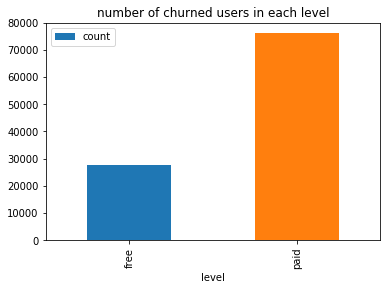

In [31]:
level_churned.plot.bar(x='level',y='count',title='number of churned users in each level')

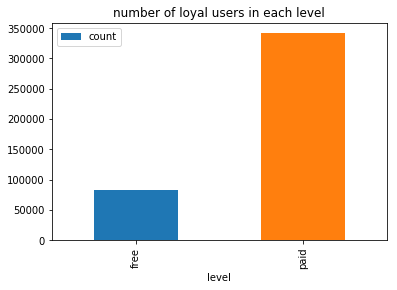

In [32]:
level_loyal.plot.bar(x='level',y='count', title='number of loyal users in each level')

Looks like there is an imbalance in the ratio of free/paid users between churned and loyal customers, in a way that free users are more likely to churn compared to paid users.

This is in agreement with our expectations, since free users don't have a committment, and enjoy the service less than paid users due to hearing annoying ads

Let's see if there is an imbalance in gender as well

In [43]:
gender_churn = data.dropDuplicates(['userid']).groupby(['churned_user','gender']).count().sort('churned_user').toPandas()

In [44]:
gender_churn

,churned_user,gender,count
0,false,M,196
1,false,F,153
2,true,F,45
3,true,M,54


In [45]:
gender_churn.index = ['Loyal_Males','Loyal_Females','Churned_Female','Churned_Male']

In [46]:
gender_churn

,churned_user,gender,count
Loyal_Males,false,M,196
Loyal_Females,false,F,153
Churned_Female,true,F,45
Churned_Male,true,M,54


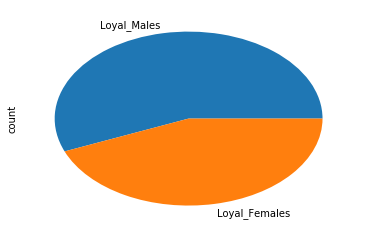

In [35]:
gender_churn[gender_churn['churned_user']=='false']['count'].plot.pie()

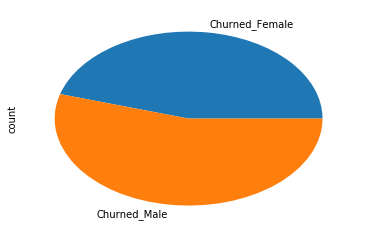

In [36]:
gender_churn[gender_churn['churned_user']=='true']['count'].plot.pie()

Given the fact that the number of men in the dataset is larger, it's acceptable that they have a higher ratio than women in both loyal and churned customers

Let's check out the location of the users who stayed loyal and the users who churned. I don't expect to see a meaningful correlation between the location and churn rate since there is no clear connection between the two

In [47]:
loc_churn = data.dropDuplicates(['userid']).groupby(['location','churned_user']).count().sort(desc('count')).toPandas()

In [48]:
loc_churn.set_index('location',drop=True,inplace=True)

In [49]:
loc_churn[loc_churn['churned_user']=='true'].head(5)

,churned_user,count
location,,
"New York-Newark-Jersey City, NY-NJ-PA",true,8
"Chicago-Naperville-Elgin, IL-IN-WI",true,7
"Los Angeles-Long Beach-Anaheim, CA",true,7
"Atlanta-Sandy Springs-Roswell, GA",true,4
"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",true,4


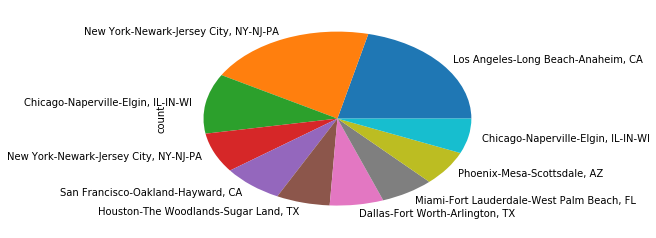

In [50]:
loc_churn.head(10).plot.pie(y='count',legend=False)

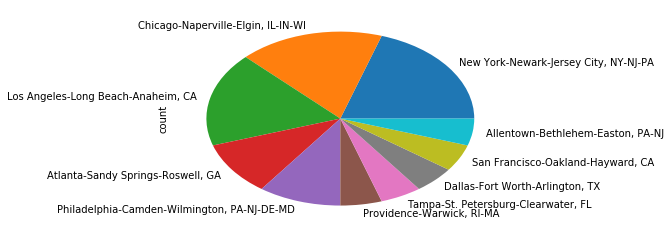

In [51]:
loc_churn[loc_churn['churned_user']=='true'].head(10).plot.pie(y='count',legend=False)

It seems that more people from New York dropped the subscription compared to California. However, we cannot generalize that since we don't have enough data points from each region to make a reasonable judgement

Now let's look at the pages that churned users and loyal users usually visit

In [52]:
churn_pages = data.where(data.churned_user=='true').groupby('page').count()

In [53]:
nochurn_pages = data.where(data.churned_user=='false').groupby('page').count()

In [54]:
churn_pages.show()

+--------------------+-----+
|                page|count|
+--------------------+-----+
|              Cancel|   99|
|    Submit Downgrade|   29|
|         Thumbs Down| 1156|
|                Home| 3778|
|           Downgrade|  831|
|         Roll Advert| 2186|
|              Logout| 1184|
|       Save Settings|  104|
|Cancellation Conf...|   99|
|               About|  185|
|            Settings|  619|
|     Add to Playlist| 2259|
|          Add Friend| 1537|
|            NextSong|84359|
|           Thumbs Up| 4300|
|                Help|  517|
|             Upgrade|  237|
|               Error|   97|
|      Submit Upgrade|   70|
+--------------------+-----+



In [55]:
nochurn_pages.show()

+----------------+------+
|            page| count|
+----------------+------+
|Submit Downgrade|    88|
|     Thumbs Down|  3755|
|            Home| 15311|
|       Downgrade|  2980|
|     Roll Advert|  5587|
|          Logout|  4806|
|   Save Settings|   481|
|           About|   841|
|        Settings|  2345|
| Add to Playlist| 10090|
|      Add Friend|  6550|
|        NextSong|348518|
|       Thumbs Up| 19526|
|            Help|  2127|
|         Upgrade|   731|
|           Error|   406|
|  Submit Upgrade|   217|
+----------------+------+



Let's get the total number of pages churned users visited

In [56]:
total_churned = data.filter(data.churned_user=='true').count()

and do the same thing for loyal users

In [57]:
total_loyal = data.filter(data.churned_user=='false').count()

In [58]:
churn_pages = churn_pages.withColumn('page_visit_churn', 100*churn_pages['count']/total_churned).sort('page')

In [59]:
nochurn_pages = nochurn_pages.withColumn('page_visit_loyal', 100*nochurn_pages['count']/total_loyal).sort('page')

Now we need to plot the ratios to see if there is a significant difference between the pages that loyal and churned customers visit.

Note that some pages such as "Cancellation Confirmation" only appear in churn pages so we need to do an outer join

In [60]:
joined_pages = churn_pages.join(nochurn_pages, "page", "outer").drop("count").toPandas()

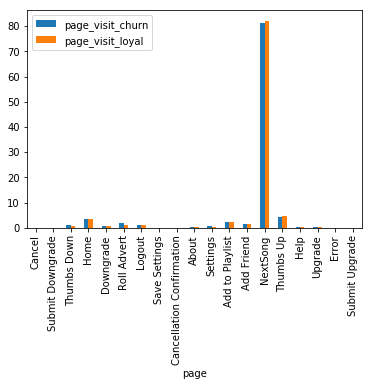

In [61]:
joined_pages.plot.bar('page')

"NextSong" Column is dominating so we can't see the rest of the columns. let's drop it and look at the data again

In [62]:
joined_pages = joined_pages[joined_pages['page'] != "NextSong"]

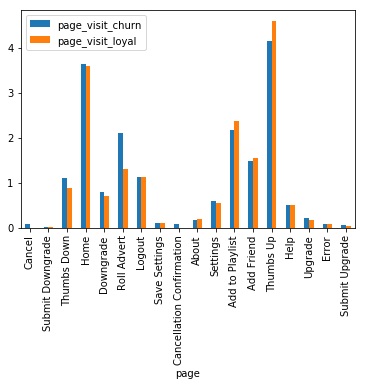

In [63]:
joined_pages.plot.bar('page')

From the plot it can be inferred that users who see an ad or give a thumbs down are more likely to churn. On contrary, giving thumbs up is more likely in loyal customers.

# Methodology

## Data Preprocessing & Feature Engineering

We looked at the ratio of free vs paid users who cancel their membership in the previous section and found a significant difference between the groups. So the "level" of membership will be our first feature

**1- We'll check to see if any member is currently a paid member**

In [64]:
user_paid = data.groupby("userid", "level").agg(max(data.ts).alias("finalTime")).sort("userid")

In [65]:
user_paid.show(5)

+------+-----+-------------+
|userid|level|    finalTime|
+------+-----+-------------+
|    10| paid|1539055364000|
|   100| paid|1543606468000|
|   100| free|1538477683000|
|100001| free|1538491859000|
|100002| paid|1541146209000|
+------+-----+-------------+
only showing top 5 rows



check out userId 100, it looks like this user has logged in the system with both free and paid memberships during different periods of time. We need to look at the most recent recording

In [66]:
user_recent_level_time = user_paid.groupby("userid").agg(max(user_paid.finalTime).alias("recent"))

In [67]:
user_recent_level = user_recent_level_time\
    .join(user_paid, [user_paid.userid == user_recent_level_time.userid, user_recent_level_time.recent == user_paid.finalTime])\
    .select(user_paid.userid, "level")\
    .sort("userid")

In [68]:
user_recent_level = user_recent_level.replace(["free", "paid"], ["0", "1"], "level")
user_recent_level = user_recent_level.select("userid", user_recent_level.level.cast("int"))

In [69]:
user_recent_level.show(5)

+------+-----+
|userid|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    0|
|100003|    1|
+------+-----+
only showing top 5 rows



**2- Let's study gender as a feature**

There was a difference in the ratio of men vs women in the dataset. This difference might be helpful in predicting churn rate


In [70]:
gender = data.select(['userid','gender']).dropDuplicates()

In [71]:
gender = gender.replace(['M','F'],['0','1'],'gender').sort('userid')

In [72]:
gender = gender.select('userid', gender.gender.cast("int"))

In [73]:
gender.show(5)

+------+------+
|userid|gender|
+------+------+
|    10|     0|
|   100|     0|
|100001|     1|
|100002|     1|
|100003|     1|
+------+------+
only showing top 5 rows



3- **Number of sessions** can be an indicator of how many times the user has used the service. This will be our next feature

In [74]:
num_sessions = data.select(['userid', 'sessionid']).dropDuplicates().groupby('userid').count()

In [75]:
num_sessions.show(5)

+------+-----+
|userid|count|
+------+-----+
|100010|    2|
|200002|    5|
|   296|    5|
|   125|    3|
|     7|   15|
+------+-----+
only showing top 5 rows



We also looked at the frequency of visiting each page for churned and loyal users. 

4- **Average Time Per Session**

In [76]:
user_time = data.groupby('userid', 'sessionid').agg(((max(data.ts)-min(data.ts))/60000).alias('sessiontime'))

In [77]:
avg_time = user_time.groupby('userid').agg(avg(user_time.sessiontime)).alias('avg_time').sort('userid')

In [78]:
avg_time.show(5)

+------+------------------+
|userid|  avg(sessiontime)|
+------+------------------+
|    10|            1502.4|
|   100| 350.4777777777778|
|100001|137.66111111111113|
|100002|          150.2625|
|100003|296.92777777777775|
+------+------------------+
only showing top 5 rows



**TARGET: Churn**

Our target was predicting churn rate, which was defined above. We need to create a column for our target along with features to train our machine learning models

In [79]:
churned = data.replace(["false", "true"], ["0", "1"], "churned_user")
churned = churned.select("userid", churned.churned_user.cast("int"))

In [80]:
churned = churned.select("userid", "churned_user").dropDuplicates()

In [81]:
churned.show(5)

+------+------------+
|userid|churned_user|
+------+------------+
|    19|           0|
|    73|           0|
|   209|           0|
|100005|           1|
|100030|           1|
+------+------------+
only showing top 5 rows



Now it's time to construct the dataframe that contains features and the target. The features that we have built so far have two columns each, one for userid and the other for the constructed feature. Therefore, we can build the final features dataframe by joining the constructed features together

We need to rename the userid column in one of the dataframes everytime we are joining them, so that we can drop one and keep the other

In [94]:
gender = gender.withColumnRenamed('userid','userid_drop')
features = user_recent_level.join(gender, user_recent_level.userid == gender.userid_drop, 'inner').drop('userid_drop')

In [95]:
num_sessions = num_sessions.withColumnRenamed('userid', 'userid_drop')
features = features.join(num_sessions, features.userid == num_sessions.userid_drop, 'inner').drop('userid_drop')

In [96]:
avg_time = avg_time.withColumnRenamed('userid', 'userid_drop')
features = features.join(avg_time, features.userid == avg_time.userid_drop, 'inner').drop('userid_drop')

In [97]:
churned = churned.withColumnRenamed('userid', 'userid_drop')
features = features.join(churned, features.userid == churned.userid_drop, 'inner').drop('userid_drop')

In [98]:
features = features.withColumnRenamed('avg(sessiontime)','avg_time')

In [99]:
features.show(5)

+------+-----+------+-----+------------------+------------+
|userid|level|gender|count|          avg_time|churned_user|
+------+-----+------+-----+------------------+------------+
|100010|    0|     1|    2|           210.375|           1|
|200002|    1|     0|    5|263.06000000000006|           1|
|   296|    1|     1|    5| 97.03666666666666|           1|
|   125|    0|     0|    3| 84.98333333333333|           0|
|   124|    1|     1|   17| 445.6676470588235|           1|
+------+-----+------+-----+------------------+------------+
only showing top 5 rows



We need to convert all the columns to numeric values

In [100]:
for col in features.columns[1:]:
    features = features.withColumn(col+'_numeric', features[col].cast("float"))
    features = features.drop(col)

In [101]:
features.show(5)

+------+-------------+--------------+-------------+----------------+--------------------+
|userid|level_numeric|gender_numeric|count_numeric|avg_time_numeric|churned_user_numeric|
+------+-------------+--------------+-------------+----------------+--------------------+
|100010|          0.0|           1.0|          2.0|         210.375|                 1.0|
|200002|          1.0|           0.0|          5.0|          263.06|                 1.0|
|   296|          1.0|           1.0|          5.0|        97.03667|                 1.0|
|   125|          0.0|           0.0|          3.0|        84.98333|                 0.0|
|   124|          1.0|           1.0|         17.0|       445.66763|                 1.0|
+------+-------------+--------------+-------------+----------------+--------------------+
only showing top 5 rows



## Implementation

Let's split the full dataset into train, test, and validation sets. We will test out several of the machine learning methods that are built into PySpark. We'll evaluate the accuracy of the various models, tuning parameters as necessary and determine our winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, we will be using F1 score as the metric to optimize

In [102]:
assembler = VectorAssembler(inputCols=features.columns[1:-1], outputCol="NumFeatures")
transformed_features = assembler.transform(features)

In [103]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True)
scalerModel = scaler.fit(transformed_features)
transformed_features = scalerModel.transform(transformed_features)

In [104]:
transformed_features = transformed_features.select(transformed_features.churned_user_numeric.alias("label"), transformed_features.ScaledNumFeatures.alias("features"))

In [105]:
train, rest = transformed_features.randomSplit([0.6, 0.4], seed=42)

test, validation = rest.randomSplit([0.5, 0.5], seed=42)


Our first candidate for the ML model will be linear logistic regression.

In [106]:
lr =  LogisticRegression()
lrModel = lr.fit(train)

In [107]:
def analyze_predictions(model, test):
    '''
    INPUTS: model: an instance of a machine learning algorithm model,
    test: test dataframe to compare predictions
    
    Description: calculates predictions and prints F1 score of the model
    when comparing the predictions with test data
    
    '''
    results = model.transform(test)
    results = results.select(['prediction','label'])
    predictionAndLabels=results.rdd
    metrics = MulticlassMetrics(predictionAndLabels)
    cm=metrics.confusionMatrix().toArray()
    accuracy=(cm[0][0]+cm[1][1])/cm.sum()
    precision=(cm[0][0])/(cm[0][0]+cm[1][0])
    recall=(cm[0][0])/(cm[0][0]+cm[0][1])
    f1 = (2*precision*recall)/(precision+recall)
    print("f1 score:",f1)

In [108]:
analyze_predictions(lrModel,test)

f1 score: 0.693333333333


Let's see if we cann get better performance out of Decision Trees

In [109]:
dt = DecisionTreeClassifier()
dtModel = dt.fit(train)

In [110]:
analyze_predictions(dtModel, test)

f1 score: 0.657534246575


Ensemble methods: RandomForestClassifier

Let's see if we can get a better performance by using ensemble methods

In [112]:
rf = RandomForestClassifier()
rfModel = rf.fit(train)

In [113]:
analyze_predictions(rfModel, test)

f1 score: 0.693333333333


## Refinement

Now it's time to change the parameters of the models to get a better performance. 

As for logistic regression model, we can change elasticNetParam pr regParam

In Decision Tree and Random Forests, we can try changing impurity and maxDepth

Since the training time is extremely long for the large dataset, we'll use small number of parameters to choose from

In [114]:
lr =  LogisticRegression()
paramGrid = ParamGridBuilder().addGrid(lr.elasticNetParam,[0.1, 1.0]).build()

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=MulticlassClassificationEvaluator(), numFolds=2)
cvlr = cv.fit(train)

In [115]:
analyze_predictions(cvlr, test)

f1 score: 0.693333333333


In [117]:
rf = RandomForestClassifier()

paramGrid = ParamGridBuilder().addGrid(rf.maxDepth,[3, 10]).build()
cv2 = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=MulticlassClassificationEvaluator(), numFolds=2)
cvrf = cv2.fit(train)

In [118]:
analyze_predictions(cvrf, test)

f1 score: 0.694444444444


It looks like we have a slight improvement in the performance of random forest classifier by implementing a grid search over maximum depth. On the other hand, an improvement was not observed with the logistic regression model. 

Given the fact that training the models were extremely time consuming, we decided to perform grid search on a limited number of parameters. However, there should be room for improvement if grid search was performed over a larger set of parameters. Top candidates for grid search on random forests would be number of estimator and minimum sample split parameters. 

# Results

## Model Evaluation and Validation

Given the performance of the models, we will be choosing the random forest classifier as the final model. this model is named cvrf. 

We wil be analyzing the performance of the random forest classifier on the validation data set to report the final F1 score of the model.

Thankfully, we have already written a function to calculate the f1 score for any model and a validation data set. 

In [119]:
analyze_predictions(cvrf, validation)

f1 score: 0.861244019139


Our final model, has a F1 score of 0.86 which is close enough to 1, therefore the model can be accepted as final. Note that F1 score is a function of precision and recall, and both type I and type II errors would punish the F1 score equally. This means that when high F1 scores are achieved, both type I and type II errors are minimal. 




## Justification

Our final model, which is a random forest classifier, has outperformed logistic regression and decision trees. This is not surprising given the fact that logistic regression is a linear classifier and may fall short of classifying more complex problems. On the other hand, a random forest is an ensemble of decision trees, in a way that each tree tries to compensate for the error in another one. Thus creating a group that is stronger than a single decision tree.

A grid search over the parameters of the random forest classifier helps us reduce bias and increase F1 score. 

In this project, due to extremely slow speed of grid search over large data sets such as in this case, we chose to perform grid search over a single parameter with only two options. This was just the proof of concept and of course the model can be improved further by performing grid search over a larger number of parameters as well as values for each parameter. However, we only expect to see slight improvements in the F1 score of the model by performing a more extensive grid search. Based on our experience in the past, significant improvements can only happen due to meaningful change in the features or algorithm rather than the parameters of the model. 


# Conclusion

## Reflection

In this project we looked at a large (half a million rows) of data about how users of a digital media provider interacted with the service. We had data about which pages they visited, which songs they listened to, their gender, the exact time of interaction and etc.

Our goal was to understand which users are more likely to churn (cancel their subscription) in order to enable our marketing team to offer them incentives such as a lower fee to avoid losing customers. 

We explored the data and decided to build four features; gender, subscription type, number of opened sessions and average time spent on each session. Our target was to predict whether the user would churn or not.

We trained three machine learning algorithms, a logistic regression model, a decision tree and also a random forest classifier. 

Our initial results indicated that logistic regression and random forest classifiers were performing better than the decision tree.

So we did fine-tuning and performed grid search on logistic regression and random forest classifiers.

After fine tuning, the random forest classifier was selected as the best model with a validation F1 score of 0.86

This project was very interesting given the fact that it represents a real world and common problem. Most of the businesses today deal with customers and need to hold on to their customers for maximum profits. 




## Improvement

While the final F1 score was good enough, there is still room for improvement.

One way of making a significant improvement would be to separate paid users from free tier users. This way the features can be built tailored to the group of interest. For example, the number of ads seen and the length of ads would be prime candidates for feature selection for the free tier users. On the other hand, the premium users don't see any ads but the might get bored with the service. Meaning that they might use the service for a while, get tired of the songs they have always listened to and if they don't look for new songs and find new artists that they like, they might get bored and cancel their premium subscription. In this case, our work as data scientist wouldn't end here and we'd need to design a great recommendation engine for the users as well!